# Introduction

[The CGIAR Wheat Growth Stage Challenge by CGIAR Platform for Big Data in Agriculture competition](https://zindi.africa/competitions/cgiar-wheat-growth-stage-challenge) is ongoing on Zindi. If you're not sure how to begin, this notebook is for you! We'll look at the data, show how you can use fastai to train a model, make predictions and submit to Zindi. Then we'll see how we could improve our score. Let's start by taking a look at the data.

# Getting the Data

The 'Data' section has three files:
- Train.csv which has the labels we'll need for training
- SampleSubmission.csv to show us the format for uploading our predictions
- Images.zip - the images themselves

Train and SampleSubmission are small, and easy enough to download to your personal machine then upload to Colab using the files panel on the left of the screen. Let's do that now, and check they're in place with the following command:

In [ ]:
!ls *.csv # Should show Train.csv and SamplaSubmission.csv

SampleSubmission.csv  Train.csv


The images are 300+MB - no point wasting bandwidth! You can add them to your google drive with this drive link: https://drive.google.com/file/d/1Cqxnj3hlJsvf0oJUpHGfqurH5wf99U6R/view?usp=sharing

Once they're in your drive, click 'Mount Drive' aboive the file list on the left. Once done, you can access files in your drive from this notebook - a useful trick. Assuming you've done that, here's how we can copy the images.zip file to our colab machine:

In [ ]:
!cp 'drive/My Drive/images.zip' images.zip # You may have them stored in a folder, in which case modify the path.

In [ ]:
# Now we can unzip:
!unzip -q images.zip

Once this is done we'll have a folder of images in our working directory. We can now start exploring the data.

# Setup

You might need to run this cell then restart your notebook to make sure the fastai version is up to date. But I've found the restart is usually not necessary - if the imports all work you're good to go :)

In [ ]:
!pip install -q --upgrade fastcore 
!pip install -q --upgrade fastai # Make sure we have the latest fastai

     |████████████████████████████████| 40kB 3.7MB/s 
     |████████████████████████████████| 358kB 7.6MB/s 


In [ ]:
import pandas as pd
from matplotlib import pyplot as plt
from PIL import Image as PImage # TO avoid confusion later
from fastai.vision.all import *

# Exploring

In this section we'll use pandas to load the labels from Train.csv, and PIL + matplotlib to view some examples of the different growth stages.

In [ ]:
# Load and view the data
train = pd.read_csv('Train.csv')
print(train.shape)
train.head()

(10695, 3)


,UID,growth_stage,label_quality
0,nwuCTQKz,4,2
1,NVGUOzWu,1,1
2,1IYVvHwA,1,1
3,8OEdWwmU,1,1
4,oc5iO04j,1,1


The images are named based on the UID. The growth_stage is our target colum - let's look at some examples:

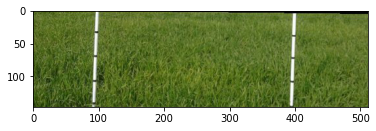

In [ ]:
# Loading and viewing an image:
im = PImage.open('images/nwuCTQKz.jpeg')
plt.imshow(im)

In [ ]:
train['growth_stage'].unique()

array([4, 1, 6, 3, 7, 2, 5])

<Figure size 432x288 with 0 Axes>

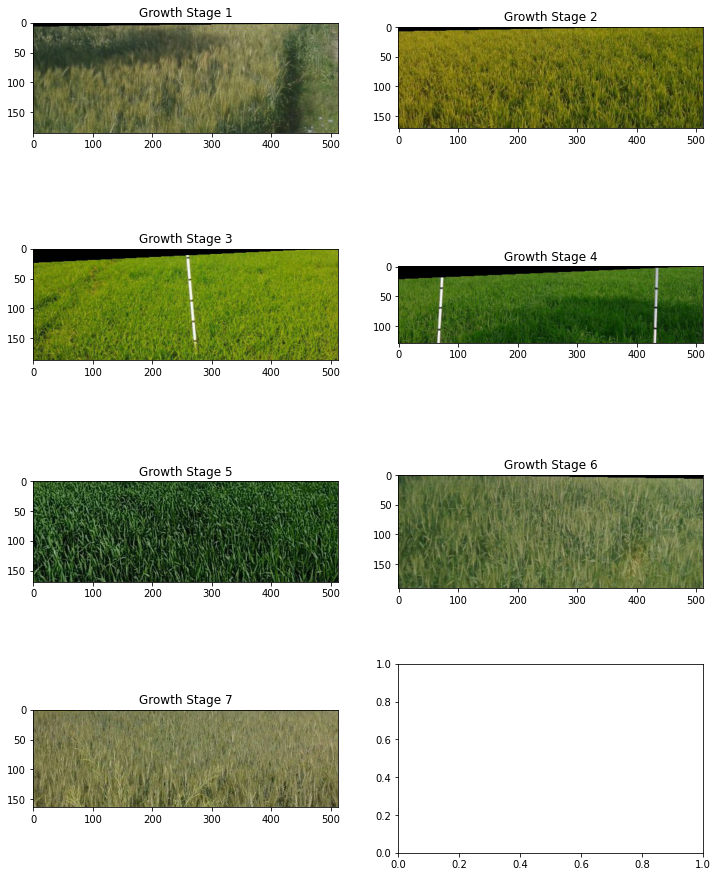

In [ ]:
# Plotting an example of each growth stage:
plt.figure()
fig, axs = plt.subplots(4, 2, figsize=(12, 16))

for i, ax in enumerate(axs.flatten()):
  if i+1 in train['growth_stage'].unique(): # If i+1 is a valid growth stage
    im_id = train.loc[(train.growth_stage == i+1)].sample()['UID'].values[0] # Get the ID of an image with the growth stage i+1
    im = PImage.open(f'images/{im_id}.jpeg')
    ax.imshow(im)
    ax.set_title( f'Growth Stage {i+1}')

In [ ]:
# HOW MANY IMS FROM EACH GROWTH PHASE DO WE HAVE?
train.growth_stage.value_counts()

1    3057
7    2335
4    1712
2    1389
5    1092
3     689
6     421
Name: growth_stage, dtype: int64

In [ ]:
# How many are high-quality?
train.loc[train.label_quality == 2].shape[0]

2856

# Preparing for Modelling

There are many ways you could approach this challenge, but in this notebook we'll use fastai to make our lives easy. We'll follow the [docs](https://https://docs.fast.ai/tutorial.vision) to build an image classifier. 

To build our dataloaders, we need a way to get the label associated with an image. The tutorial shows using the folder name, but we have a dataframe. Fortunately, there's a convenience function to let us specify labels like this.

In [ ]:
# doc(ImageDataLoaders.from_df) # Run this to see what arguments this function takes

In [ ]:
# For now, let's only use the higher quality labels. THis will speed up training. We can add in the rest later.
train_hq = train.loc[train.label_quality == 2]

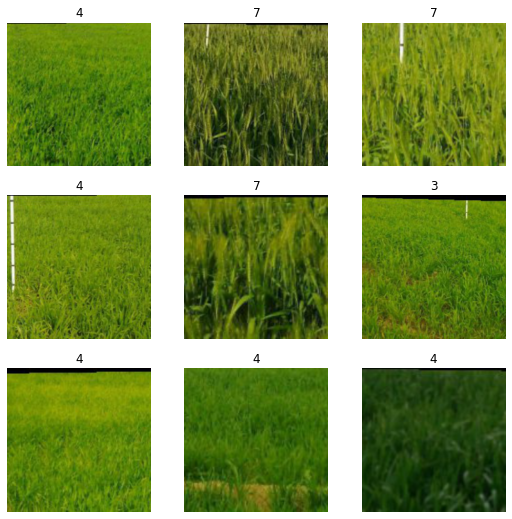

In [ ]:
# Create our dataloaders
dls = ImageDataLoaders.from_df(train_hq, path='images/', suff='.jpeg', label_col='growth_stage', item_tfms=Resize(224))
dls.show_batch()

You can see we have images and the associated labels - all good to go for modelling! Behind the scenes fastai is cropping in to a square and doing some data augmentation for us - we can play with this at a later stage to see if we can make better use of this functionality.

# Training a Model

Here we download a pretrained model and fine-tune it on this task. It's scarily simple to do:

In [ ]:
learn = cnn_learner(dls, resnet34, metrics=error_rate)
learn.fine_tune(3) # the 3 here tells it to train the head then fine-tune the whole network for 3 epochs

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth


epoch,train_loss,valid_loss,error_rate,time
0,1.700256,0.834892,0.271454,00:10


epoch,train_loss,valid_loss,error_rate,time
0,1.031514,0.748705,0.267951,00:10
1,0.870570,0.629246,0.229422,00:10
2,0.741385,0.552236,0.224168,00:10


You can train longer, and get fancier in terms of setting learning rates etc. Let's do that later - for now, how do we submit?

# Saving Predictions

TO make predictions for the test set, we need to make a dataloader similar to the one used for training. We'll load the sample submission (which has the test image ids), create a test dataloader and make predictions.

In [ ]:
ss = pd.read_csv('SampleSubmission.csv')
ss.head()

,UID,growth_stage
0,F3LbWkZq,0
1,6P4wLVzI,0
2,Tn6HIrdS,0
3,EYM5R1TK,0
4,fkcevlA0,0


In [ ]:
tdl = learn.dls.test_dl(ss) # Make test dataloader

In [ ]:
preds = learn.get_preds(dl=tdl) # Get model predictions

In [ ]:
preds[0].shape # 5 sets of probabilities - one for each class. The high quality labels must not cover a few of the growth phases

torch.Size([3558, 5])

In [ ]:
preds[0][0] # The predictions for the first test image

tensor([6.8161e-04, 2.3909e-05, 1.3629e-01, 6.8130e-01, 1.8171e-01])

In [ ]:
learn.dls.vocab # The classes associated with the probabilities output

(#5) [2,3,4,5,7]

In [ ]:
# Converting the predicted probabilities into classes:
class_indexes = np.argmax(preds[0], axis=1)
classes = [learn.dls.vocab[idx] for idx in class_indexes]
classes[:3] # We've found the class with the highest probability - these are our predictions

[5, 4, 3]

In [ ]:
# Update the submission dataframe with our predictions
ss['growth_stage'] = classes
ss.head()

,UID,growth_stage
0,F3LbWkZq,5
1,6P4wLVzI,4
2,Tn6HIrdS,3
3,EYM5R1TK,4
4,fkcevlA0,7


In [ ]:
# Save and submit
ss.to_csv('sub1.csv', index=False)

This file can be downloaded and submitted on Zindi - Congrats - you made your first entry :) 

It scored 0.63 (25th place) when I ran this.

Now it's time to see if we can improve further - this next sections will repeat the modelling process again, with some extra tricks to boost our score.

# Is Classification the way to go?

The task is framed as a regression task - that is, predict a number between 1 and 7. The metric is RMSE, the root mean squyared error, a measure of how far your predictions are from the actual.

By treating this as a classification task, we restrict our predictions to the integer outputs - not ideal. What if your model isn't sure if it's stage 4 or 5? You might have probability 0.4 that it's 4, and 0.56 that it's 5, and so you submit a 5, but then if the true class is four you're poenalized heavily. 

We'll show how to do regression in the next section, but we can also use our predicted probabilities from above, with a modification to how we turn our probabilities into outputs. For the example above, what if we did 0.4 * 4 + 0.56 * 5 +... - we'd get a predictions somewhere between the two - just what we want. In code, this looks like:

In [ ]:
ss = pd.read_csv('SampleSubmission.csv')
ss['growth_stage'] = (preds[0] * tensor([int(c) for c in learn.dls.vocab])).sum(dim=1)
ss.head() # Now we have outputs that aren't restricted to the integer growth phase numbers

,UID,growth_stage
0,F3LbWkZq,5.225048
1,6P4wLVzI,3.995394
2,Tn6HIrdS,3.003898
3,EYM5R1TK,4.123218
4,fkcevlA0,6.762642


In [ ]:
ss.to_csv('sub2.csv', index=False)

This scores ~0.55, putting us in the top 20 :) 
It's not ideal however - we'd like to be able to guess our score as we train, and to directly output a continuous prediction rather than going the roundabout route...

# Regression

The task is to estimate the growth phase as a continuous variable, with the objective being to minimise RMSE. So the first big change we'll make is re-framing this as a regression challenge.

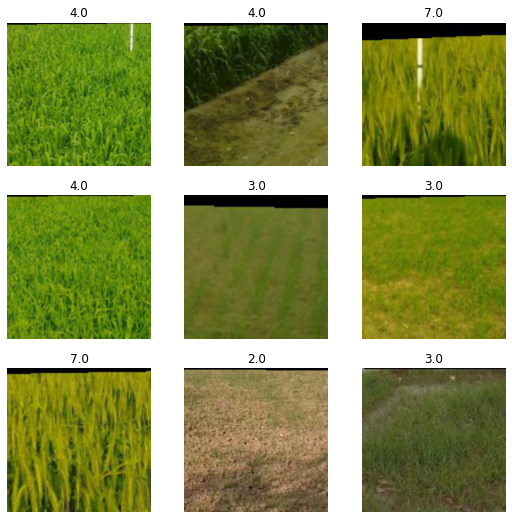

In [ ]:
dls = ImageDataLoaders.from_df(train_hq, # train_hq if you only want the smaller high-quality set of images
                               path='images/', suff='.jpeg', label_col='growth_stage', item_tfms=Resize(224), 
                               y_block=RegressionBlock) # The only other change!
dls.show_batch()

By specifying the y_block as a RegressionBlock, we tell fastai that we want to do regression and to treat the labels as a continuous variable. The rest of the code looks fairly similar:

In [ ]:
learn = cnn_learner(dls, resnet34, metrics=rmse) # A new metric
learn.fine_tune(15) # Train a little longer

epoch,train_loss,valid_loss,_rmse,time
0,17.324146,12.300617,3.507223,00:10


epoch,train_loss,valid_loss,_rmse,time
0,12.145437,9.818573,3.133460,00:10
1,11.046947,7.794713,2.791902,00:10
2,9.297537,4.923276,2.218846,00:10
3,7.166852,3.134388,1.770420,00:10
4,5.505037,1.696680,1.302567,00:10
5,4.331344,1.358502,1.165548,00:10
6,3.479995,1.013786,1.006869,00:10
7,2.922189,0.961954,0.980793,00:10
8,2.440849,0.639176,0.799485,00:10
9,2.138702,0.597857,0.773212,00:10


In [ ]:
tdl = learn.dls.test_dl(ss) # Make test dataloader
preds = learn.tta(dl=tdl) # Test Time Augmentation

In [ ]:
ss['growth_stage'] = preds[0].numpy() # This time our outputs are in the format we want, so this part is much easier
ss.to_csv('sub3.csv', index=False)

In [ ]:
ss.head()

,UID,growth_stage
0,F3LbWkZq,4.664308
1,6P4wLVzI,3.820368
2,Tn6HIrdS,2.686554
3,EYM5R1TK,4.393988
4,fkcevlA0,6.188190


This scores ~0.58, so not quite as good yet as the previous submission. But now we can see the RMSE during training and start playing with ways to improve. The next section has some suggestions.

# Improving your score
 There are a few different ways to improve your score. For example:

 ### 1) Ensembles

 I'm generally not a fan of large ensembles, but combining several different models can give more robust overall predictions. Just make sure you document everything so it's reproducible! Here I'll combine sub2 and sub3 and see how the combination does:

In [ ]:
import pandas as pd
sub2 = pd.read_csv('place22.csv')
sub3 = pd.read_csv('place18.csv')
sub4 = pd.read_csv('place11.csv')
sub5 = pd.read_csv('place17.csv')
merged = sub2 # Will give two columns of preds - growth_stage_x and growth_stage_y
merged['growth_stage'] = (sub2['growth_stage'] + sub3['growth_stage'] + sub4['growth_stage'] + sub5['growth_stage'])/4
merged[['UID', 'growth_stage']].to_csv('place23.csv', index=False)

This scores 0.528, our best score yet!

2) Test Time Augmentation

In the regression section, did you notice that I replaced learn.get_preds() with learn.tta()? This is a free boost to your score - the model will make predictions for four different versions of each input image and take the average. A useful technique to know! This is one reason why our score on Zindi was better than the RMSE shown during training - there is no TTA when the validfation RMSE is calculated. 

3) Image Augmentation

Fastai makes it easy to add image augmentation - check out the docs for some diffeent parameters you can tweak: https://docs.fast.ai/vision.augment (especially the aug_transforms section)

4) More Training

We did very quick training runs here - even just inccreasing the number of epochs to fine-tune will get an improvement in your score. You can also get fancier with how you train, using the lr_find method to pick learning rates and so on (there are lots of good fastai tutorials out there with instructions)

5) Better models

We're using the resnet34 architecture - not bad, but not the latest greatet model either. A larger model like densenet201 could take longer to train and might be more complex, but you can sometimes get better performance by scaling up.

6) Use all the training data!

We used only the high quality images for this notebook! You may find that training on all the images gives a lower score, but it seems a waste to let all that data go unused. A technique I've found useful: Train on all the images, then re-train on the ones with high-quality labels. 

Another option here would be to use your best model trained on the high-quality labels to generate pseudo-labels for the other images, and train with those. It sounds circular, but this is a known technique that works surprisingly well :)

7) Get creative - I'm sure there are all sorts of other fun ways to squeeze some extra performance out :)

Enjoy, and good luck. 

This notebook made with love by Jonathan Whitaker

PS: I'm on holiuday for the next few days, but happy to answer questions when I get back - pop them in the discussion boards and tag me :)